In [1]:
from matplotlib import pyplot as plt
from torch import nn
from tqdm import tqdm
from dataset.FastPatchExtractor import FastPatchDataset, FastPatchExtractor
import torch

from operators.gaussian_blur import gaussian_kernel_generator, BlurOperator
from operators.noise_operator import append_noise
from patchNR.model import create_NF
from skimage.metrics import structural_similarity as ssim

ImportError: cannot import name 'gaussian_kernel_generator' from 'operators.gaussian_blur' (/home/jupyter/nf-for-inv-problems/operators/gaussian_blur.py)

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cpu


### Load GT Image and create the blurred degraded input image

In [3]:
file = "./data/material_pt_nr/test.png"
ground_truth_image = FastPatchDataset.load_image(file)

In [4]:
blur_kernel_size = 11
blur_kernel_std = 2
noise_std=1

In [5]:
kernel = gaussian_kernel_generator(blur_kernel_size, blur_kernel_std).to(DEVICE)
blur_operator = BlurOperator(kernel, device=DEVICE)
blurred_image = blur_operator(ground_truth_image)
blurred_image_noisy = append_noise(blurred_image, std=noise_std, device=DEVICE)

In [7]:
def plot_images(img0, img1, img2, selected_patch=0, p_size=30):
    image0 = img0.to('cpu')
    image1 = img1.to('cpu')
    image2 = img2.to('cpu')
    out_dim = (p_size, p_size)
    patch_extractor = FastPatchExtractor(p_dim=p_size)
    p_image0 = torch.reshape(patch_extractor.extract(image0.unsqueeze(0))[selected_patch], out_dim)
    p_image1 = torch.reshape(patch_extractor.extract(image1.unsqueeze(0))[selected_patch], out_dim)
    p_image2 = torch.reshape(patch_extractor.extract(image2.unsqueeze(0))[selected_patch], out_dim)
    fig, axes = plt.subplots(2, 3, figsize=(10, 5))
    axes[0][0].imshow(image0.squeeze(), cmap='gray')
    #axes[0][0].set_title('Clean')
    axes[0][0].axis('off')
    axes[0][1].imshow(image1.squeeze(), cmap='gray')
   # axes[0][1].set_title(f'Gaussian Blur with k={blur_kernel_size} and std={blur_kernel_std}')
    axes[0][1].axis('off')

    axes[0][2].imshow(image2.squeeze(), cmap='gray')
   # axes[0][2].set_title(f'Blur + Gaussian noise std={noise_std}')
    axes[0][2].axis('off')

    axes[1][0].imshow(p_image0.squeeze(), cmap='gray')
    axes[1][0].axis('off')

    axes[1][1].imshow(p_image1.squeeze(), cmap='gray')
    axes[1][1].axis('off')

    axes[1][2].imshow(p_image2.squeeze(), cmap='gray')
    axes[1][2].axis('off')
    plt.tight_layout()
    plt.show()

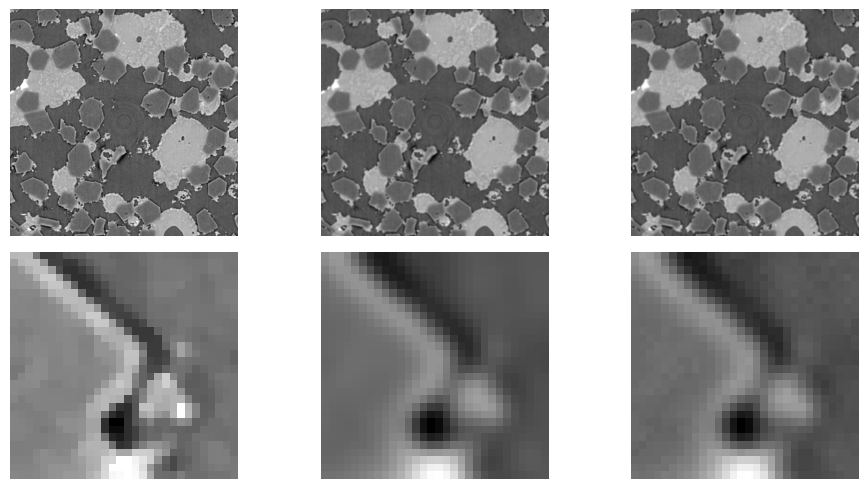

In [8]:
plot_images(ground_truth_image, blurred_image, blurred_image_noisy, selected_patch=110, p_size=30)

### Load model

In [9]:
weight = 'patchNR/patchNR_weights/weights_material.pth'

In [10]:
patch_size = 6
num_layers = 5
subnet_nodes = 512
net = create_NF(num_layers, subnet_nodes, dimension=patch_size**2)
weights = torch.load(weight, map_location=DEVICE)
net.load_state_dict(weights['net_state_dict'])

<All keys matched successfully>

In [15]:
from torch.utils.tensorboard import SummaryWriter

def reconstruct(observation, start, lam, patch_size, n_patches_out, model, operator, n_iter_max):
    model.to(DEVICE)

    summaryWriter = SummaryWriter()

    obs = observation.to(DEVICE)
    operator = operator
    center = False
    init = start.to(DEVICE)
    pad_size = 4
    pad = [pad_size]*4

    p_extractor = FastPatchExtractor(patch_size, pad=False, center=center, device=DEVICE)

    fake_img = torch.tensor(init.clone(), dtype=torch.float32, device=DEVICE, requires_grad=True)
    optim_img = torch.optim.Adam([fake_img], lr=0.005)
    bar = tqdm(range(n_iter_max))
    loss_list = []
    # Main loop
    for it in tqdm(range(n_iter_max)):
        optim_img.zero_grad()
        tmp = nn.functional.pad(fake_img, pad, mode='reflect')
        fake_data = p_extractor.extract(tmp, n_patches_out)
        pred_inv, log_det_inv = model(fake_data,rev=True)
        #regularizer
        reg = torch.mean(torch.sum(pred_inv**2,dim=1)/2) - torch.mean(log_det_inv)
        #data fidelity
        data_fid = torch.sum((operator(fake_img) - obs)**2)
        #loss
        loss = data_fid + lam*reg
        summaryWriter.add_scalar('Data', data_fid, it)
        summaryWriter.add_scalar('Reg', reg, it)
        summaryWriter.add_scalar('Loss', loss, it)
        loss_list.append([data_fid, reg, loss])
        bar.set_description_str('D/R: {data:.2f}  - {reg:.2f} | L: {loss:.2f} '.format(data=data_fid, reg=reg, loss=loss))
        loss.backward()
        optim_img.step()
    return fake_img, loss_list

In [16]:
lam = 0.87
n_pat = 80000
iteration = 300

rec, loss = reconstruct(blurred_image_noisy, blurred_image_noisy, lam = lam, patch_size = patch_size, n_patches_out = n_pat,
              model = net, n_iter_max = iteration, operator=blur_operator)

/tmp/ipykernel_19739/3228739226.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_img = torch.tensor(init.clone(), dtype=torch.float32, device=DEVICE, requires_grad=True)
  0%|          | 0/300 [00:00<?, ?it/s]
D/R: 91.78  - -145.98 | L: -35.22 :   0%|          | 0/300 [00:02<?, ?it/s]
D/R: 76.92  - -144.96 | L: -49.20 :   0%|          | 0/300 [00:10<?, ?it/s]
D/R: 64.39  - -146.77 | L: -63.30 :   0%|          | 0/300 [00:18<?, ?it/s]
D/R: 54.23  - -149.47 | L: -75.81 :   0%|          | 0/300 [00:27<?, ?it/s]
  1%|▏         | 4/300 [00:35<44:04,  8.93s/it]


KeyboardInterrupt: 

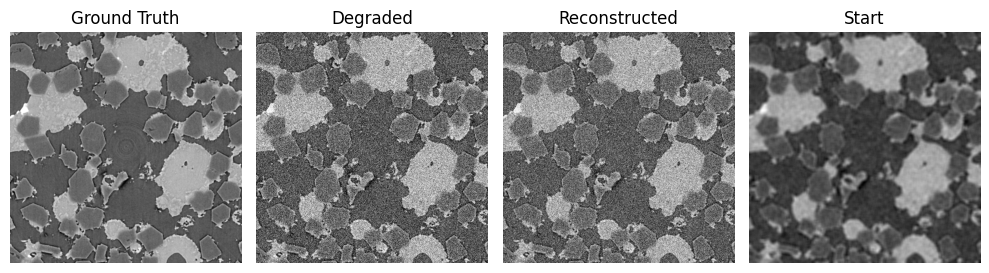

In [14]:
reconstructed = rec.detach().cpu().squeeze()
expected = rec_image.squeeze().cpu()
degraded = deg_rec_image.squeeze().cpu()
# Create a figure with two subplots arranged horizontally
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
axes[0].imshow(expected, cmap='gray')
axes[0].set_title('Ground Truth')
axes[0].axis('off')
axes[1].imshow(degraded, cmap='gray')
axes[1].set_title('Degraded')
axes[1].axis('off')
axes[2].imshow(reconstructed, cmap='gray')
axes[2].set_title(f'Reconstructed')
axes[2].axis('off')
axes[3].imshow(starting_point.squeeze(), cmap='gray')
axes[3].set_title(f'Start')
axes[3].axis('off')
plt.tight_layout()
plt.show()

In [15]:
print(f'Ground Truth and Degraded SSIM: {ssim(ground_truth, reconstructed.numpy(), data_range=1)}')

Ground Truth and Degraded SSIM: 0.21279647405641355


In [61]:
patch_extractor = FastPatchExtractor(50)

In [ ]:
patch_extractor.extract(rec)[3]

NameError: name 'patch_extractor' is not defined

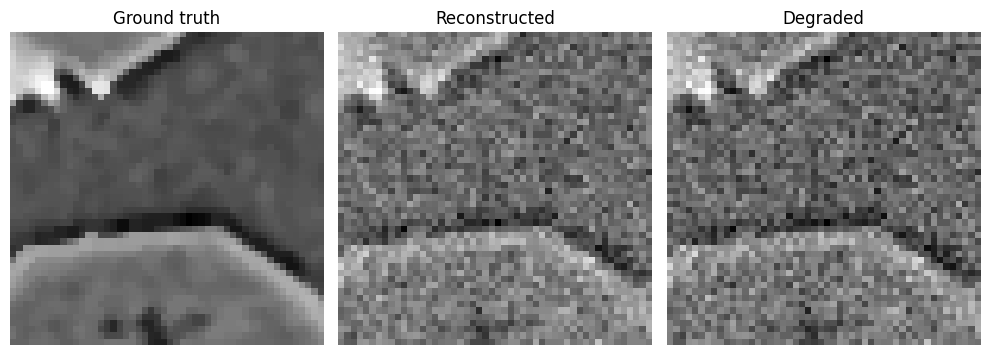

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(ground_truth, cmap='gray')
axes[0].set_title('Ground truth')
axes[0].axis('off')
axes[1].imshow(reconstructed, cmap='gray')
axes[1].set_title('Reconstructed')
axes[1].axis('off')
axes[2].imshow(deg_rec_image, cmap='gray')
axes[2].set_title(f'Degraded')
axes[2].axis('off')
plt.tight_layout()
plt.show()